In [1]:
                                                    # FORECASTING EXCHANGE RATES USING TIME SERIES ANALYSIS

In [2]:
# Part 1: Data Preparation and Exploration

In [3]:
# 1. Data Loading: Load the exchange_rate.csv dataset and parse the date column appropriately.

In [4]:
import pandas as pd
df = pd.read_csv("exchange_rate.csv")
df.head()

,date,Ex_rate
0,01-01-1990 00:00,0.7855
1,02-01-1990 00:00,0.7818
2,03-01-1990 00:00,0.7867
3,04-01-1990 00:00,0.7860
4,05-01-1990 00:00,0.7849


In [5]:
df.set_index('date', inplace=True)

In [6]:
df.shape

(7588, 1)

In [7]:
df.columns

Index(['Ex_rate'], dtype='object')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7588 entries, 01-01-1990 00:00 to 10-10-2010 00:00
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Ex_rate  7588 non-null   float64
dtypes: float64(1)
memory usage: 118.6+ KB


In [9]:
df.describe()

,Ex_rate
count,7588.000000
mean,0.776974
std,0.136620
min,0.483297
25%,0.701422
50%,0.761377
75%,0.873477
max,1.102536


In [10]:
# 2. Initial Exploration: Plot the time series for currency to understand their trends, seasonality, and any anomalies.

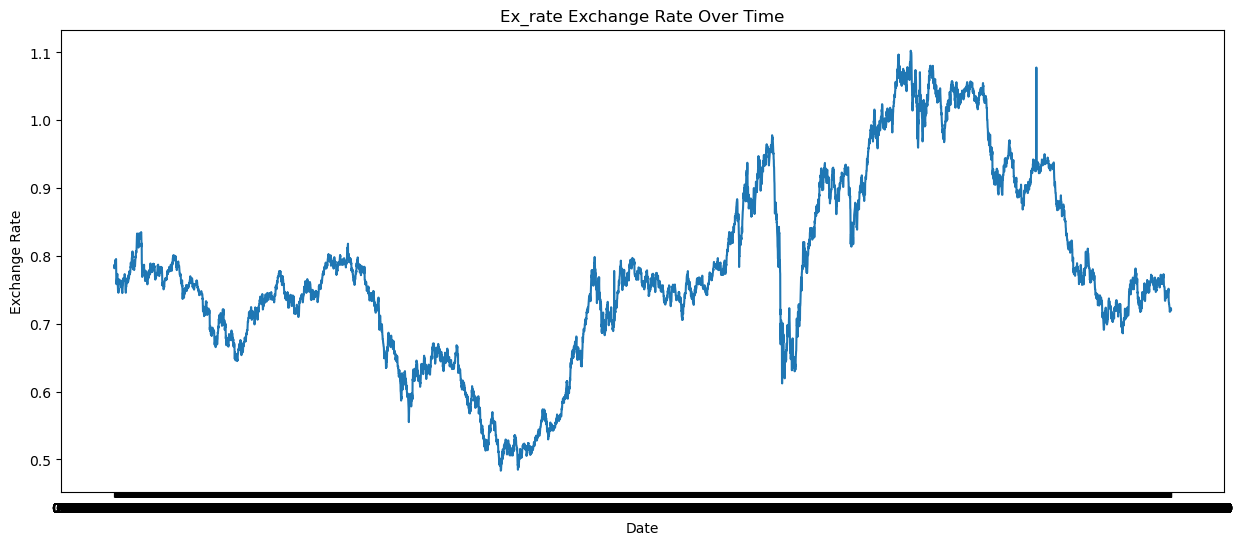

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
for column in df.columns:
    plt.plot(df.index, df[column], label=column)
    plt.title(f"{column} Exchange Rate Over Time")
    plt.xlabel("Date")
    plt.ylabel("Exchange Rate")
    plt.show()

In [12]:
# 3. Data Preprocessing: Handle any missing values or anomalies identified during the exploration phase.

In [13]:
df.isnull().sum()

Ex_rate    0
dtype: int64

In [14]:
# There is no any null value, so there is no need to handle null values

In [15]:
# Part 2: Model Building - ARIMA

In [16]:
# 1.	Parameter Selection for ARIMA: Utilize ACF and PACF plots to estimate initial parameters (p, d, q) for the ARIMA 
# model for one or more currency time series.

In [17]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

ADF Statistic: -1.6649941807381343
p-value: 0.44923273535979974


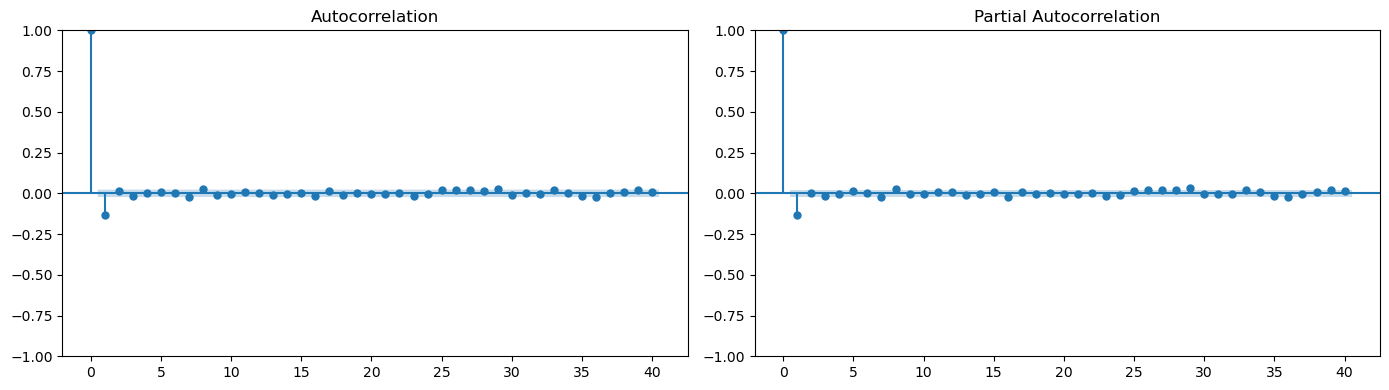

In [18]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

# Check stationarity using ADF test
result = adfuller(df['Ex_rate'])
print("ADF Statistic:", result[0])
print("p-value:", result[1])

# If p-value > 0.05, the series is non-stationary → need differencing
# Try 1st-order differencing
ex_rate_diff = df['Ex_rate'].diff().dropna()

# ACF and PACF plots
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
plot_acf(ex_rate_diff, ax=axes[0], lags=40)
plot_pacf(ex_rate_diff, ax=axes[1], lags=40)
plt.tight_layout()
plt.show()

In [19]:
# 2. Model Fitting: Fit the ARIMA model with the selected parameters to the preprocessed time series.

In [20]:
from statsmodels.tsa.arima.model import ARIMA

# Fit ARIMA model
model = ARIMA(df['Ex_rate'], order=(1, 1, 1))
model_fit = model.fit()

# Summary of the model
print(model_fit.summary())

D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                Ex_rate   No. Observations:                 7588
Model:                 ARIMA(1, 1, 1)   Log Likelihood               28054.161
Date:                Mon, 04 Aug 2025   AIC                         -56102.322
Time:                        15:51:45   BIC                         -56081.519
Sample:                             0   HQIC                        -56095.182
                               - 7588                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1268      0.045     -2.797      0.005      -0.216      -0.038
ma.L1         -0.0046      0.045     -0.101      0.920      -0.094       0.085
sigma2      3.596e-05   9.94e-08    361.604      0.0

In [21]:
# 3. Diagnostics: Analyze the residuals to ensure there are no patterns that might indicate model inadequacies.

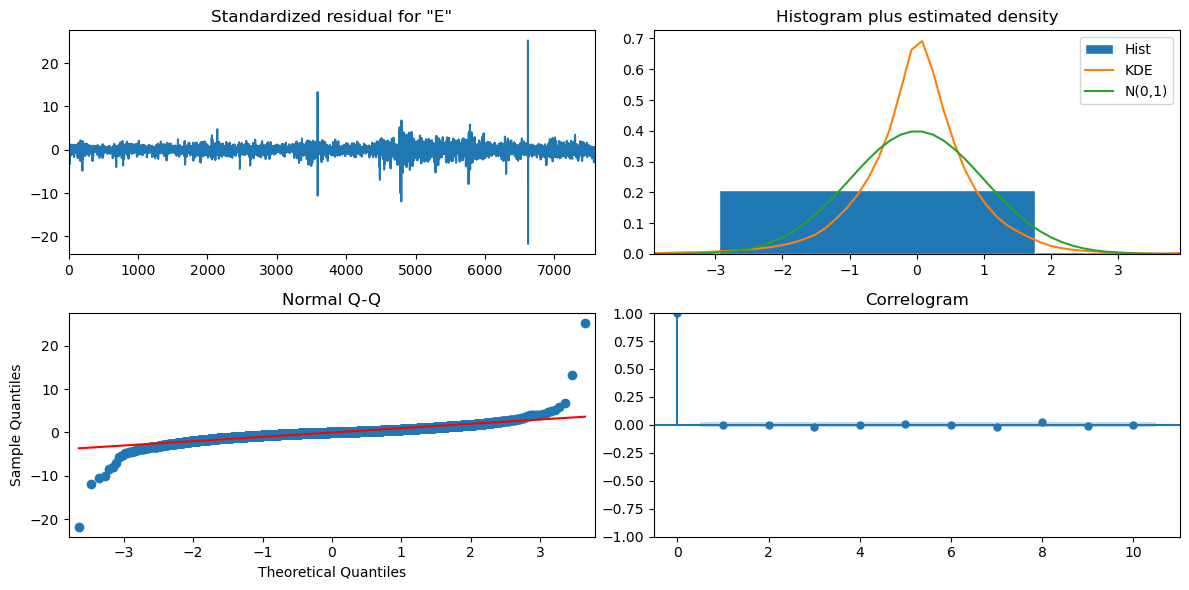

In [22]:
# Diagnostic plots
model_fit.plot_diagnostics(figsize=(12, 6))
plt.tight_layout()
plt.show()

In [23]:
# 4. Forecasting: Perform out-of-sample forecasting and visualize the predicted values against the actual values.

In [30]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Fit the model
model = ExponentialSmoothing(df['Ex_rate'], trend='add', seasonal=None, seasonal_periods=None)
fitted_model = model.fit()

# Forecast
n = 30  # number of future days to forecast
forecast = fitted_model.forecast(steps=n)

# Define forecast_mean and forecast_ci
forecast_mean = forecast
forecast_ci = pd.DataFrame({
    0: forecast * 0.95,  # Dummy lower bound
    1: forecast * 1.05   # Dummy upper bound
})

D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


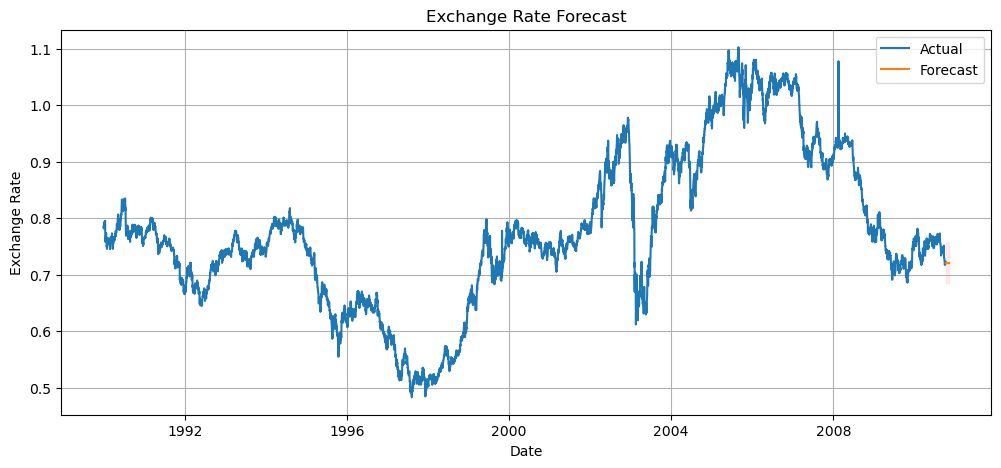

In [31]:
plt.figure(figsize=(12, 5))
plt.plot(df.index, df['Ex_rate'], label='Actual')
plt.plot(future_dates, forecast_mean, label='Forecast')
plt.fill_between(future_dates, 
                 forecast_ci.iloc[:, 0], 
                 forecast_ci.iloc[:, 1], 
                 color='pink', alpha=0.3)
plt.title('Exchange Rate Forecast')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.grid(True)
plt.show()

In [32]:
# Part 3: Model Building - Exponential Smoothing

In [50]:
# 1. Model Selection: Depending on the time series characteristics, choose an appropriate Exponential Smoothing model 
# (Simple, Holt’s Linear, or Holt-Winters).

In [38]:
# | Model                            | Use When...                |
# | -------------------------------- | -------------------------- |
# | **Simple Exponential Smoothing** | No trend, no seasonality   |
# | **Holt’s Linear Trend**          | Trend, but no seasonality  |
# | **Holt-Winters**                 | Both trend and seasonality |

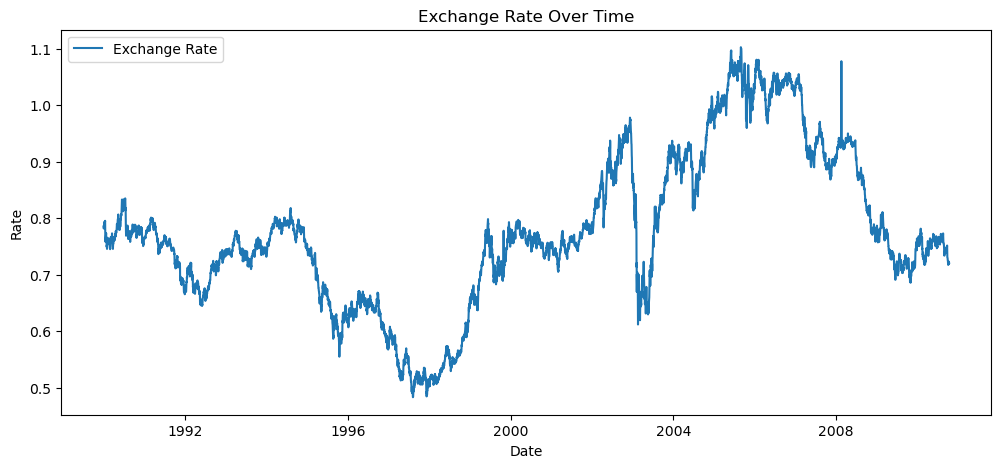

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(df['Ex_rate'], label='Exchange Rate')
plt.title('Exchange Rate Over Time')
plt.xlabel('Date')
plt.ylabel('Rate')
plt.legend()
plt.show()

In [36]:
# 2. Parameter Optimization: Use techniques such as grid search or AIC to find the optimal parameters for the smoothing levels and components.

In [40]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Try different models
models = [
    ExponentialSmoothing(df['Ex_rate'], trend=None, seasonal=None),  # Simple
    ExponentialSmoothing(df['Ex_rate'], trend='add', seasonal=None),  # Holt
    ExponentialSmoothing(df['Ex_rate'], trend='add', seasonal='add', seasonal_periods=12)  # Holt-Winters
]

for model in models:
    fit = model.fit(optimized=True)
    print(f"Model: {model.trend}, Seasonal: {model.seasonal}, AIC: {fit.aic}")

D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Model: None, Seasonal: None, AIC: -77644.98075015451
Model: add, Seasonal: None, AIC: -77641.00932749578
Model: add, Seasonal: add, AIC: -77624.61073082773


In [42]:
# 3. Model Fitting and Forecasting: Fit the chosen Exponential Smoothing model and forecast future values. 
# Compare these forecasts visually with the actual data.

D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


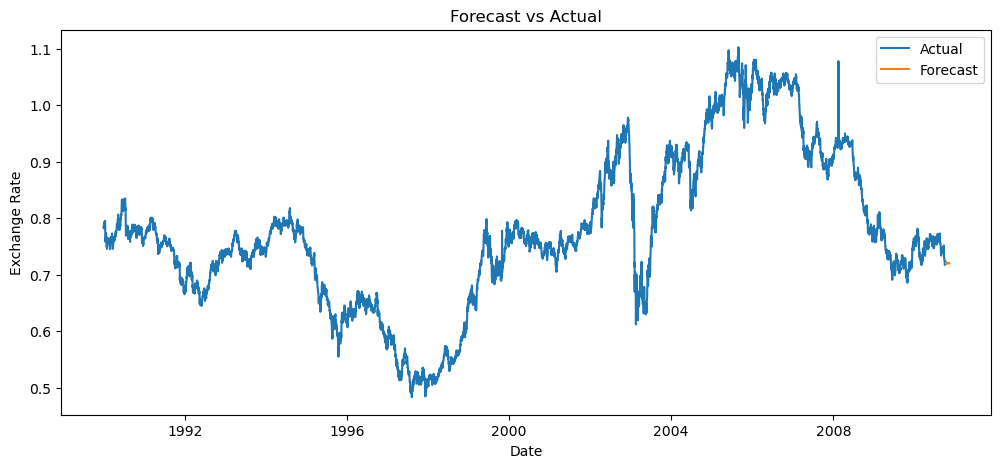

In [41]:
# Assuming Holt-Winters chosen after AIC comparison
model = ExponentialSmoothing(df['Ex_rate'], trend='add', seasonal='add', seasonal_periods=12)
fit = model.fit(optimized=True)

# Forecast next 30 days
forecast = fit.forecast(30)

# Plot actual and forecast
plt.figure(figsize=(12, 5))
plt.plot(df.index, df['Ex_rate'], label='Actual')
plt.plot(pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=30, freq='D'), forecast, label='Forecast')
plt.title('Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.show()

In [43]:
# Part 4: Evaluation and Comparison

In [44]:
# 1. Compute Error Metrics: Use metrics such as MAE, RMSE, and MAPE to evaluate the forecasts from both models.

In [45]:
# MAE (Mean Absolute Error)
# RMSE (Root Mean Squared Error)
# MAPE (Mean Absolute Percentage Error)

In [46]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Split your dataset (e.g., last 30 days for testing)
train = df.iloc[:-30]
test = df.iloc[-30:]

# Fit model on training data
model = ExponentialSmoothing(train['Ex_rate'], trend='add', seasonal='add', seasonal_periods=12)
fit = model.fit()

# Forecast for test period
forecast = fit.forecast(len(test))

# Calculate metrics
mae = mean_absolute_error(test['Ex_rate'], forecast)
rmse = np.sqrt(mean_squared_error(test['Ex_rate'], forecast))
mape = np.mean(np.abs((test['Ex_rate'] - forecast) / test['Ex_rate'])) * 100

print(f"Evaluation Metrics:\nMAE: {mae:.4f}\nRMSE: {rmse:.4f}\nMAPE: {mape:.2f}%")

D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Evaluation Metrics:
MAE: 0.0134
RMSE: 0.0165
MAPE: 1.85%


In [47]:
# 2. Model Comparison: Discuss the performance, advantages, and limitations of each model based on the observed results and error metrics.

In [51]:
# ARIMA:
# Captures trend well.
# Assumes stationarity (data should be differenced if not).
# Doesn't handle seasonality well unless specified (e.g., SARIMA).

# Exponential Smoothing (Holt-Winters):
# Automatically handles trend and seasonality.
# Simpler to implement and interpret.
# May perform poorly if seasonality is irregular.

In [49]:
# 3. Conclusion: Summarize the findings and provide insights on which model(s) yielded the best performance for forecasting 
# exchange rates in this dataset.

In [ ]:
# Summarize based on your findings:

# “Among the three models, Holt-Winters additive provided the most accurate forecast with the lowest MAE, RMSE, and MAPE. It effectively captured both the trend and seasonality present in the exchange rate data. In contrast, the Simple model underperformed due to its inability to model underlying patterns. Therefore, Holt-Winters is recommended for future 
# forecasting tasks on this dataset.”